In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import sys
sys.path.insert(0, '../Imitator')
# from plot_helper import * 

colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
]

In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import os
from pathlib import Path
import sys
import Imitate
from Imitate import *
import RegressionImitator
from RegressionImitator import *
import pandas
import seaborn as sns
from time import strftime
from time import gmtime

colors = [
    "tab:blue",
    "tab:orange",
    "tab:purple",
    "tab:red",
    "tab:green",
    "tab:brown",
    "tab:pink",
]

def get_network_name(m):
    name = m.split("-")[1]
    if name[0:3] == "xse":
        name = (
            name.replace("xse", "X-SE")
            .replace("_res", "-Res")
            .replace("net", "Net")
            .replace("next", "NeXt")
        )
    elif name[0] == "x":
        name = (
            name.capitalize()
            .replace("net", "Net")
            .replace("resnext", "ResNeXt")
            .replace("res", "-Res")
        )
    elif "squeeze" in name:
        name = name.capitalize().replace("_", "-").replace("net", "Net")
    elif "vgg" in name:
        name = name.replace("vgg", "VGG").replace("bn", "BN").replace("_", "-")
    elif "dense" in name:
        name = name.capitalize().replace("net", "Net")
    elif name[0:3] == "res":
        name = name.capitalize().replace("net", "Net")
    elif "alex" in name:
        name = name.capitalize().replace("net", "Net")

    if "deep" in name and "deeper" not in name:
        name = name.replace("_deep", "b")
    elif "deeper" in name:
        name = name.replace("_deeper", "c")
    else:
        name = name + "a"

    if (
        ("Squeeze" in name)
        or ("VGG" in name)
        or ("ResNext" in name and "SE" not in name)
        or ("ResNet" in name and "SE" in name)
        or ("Dense" in name)
        or ("Alex" in name)
        or ("ResNet" in name and "SE" not in name and "X-" not in name)
    ):
        name = name[:-1]

    return name

def get_clean_names(m):
    return m.split("-")[1]

def index_one(num):
    return num[0]

def get_df(data_dict, mazes):
    df = pd.DataFrame.from_dict(data_dict)
    df = df.assign(Maze=mazes)
    df = df.T
    df.columns = df.iloc[-1]
    df = df.drop(df.index[-1])
    # df['Network'] = df.index
    df = df.reset_index()
    df.rename(columns={'index':'Network'}, inplace=True)
    df['std'] = df[df.columns[1:]].std(axis=1)
    df['mean'] = df[df.columns[1:-1]].mean(axis=1)
    # df = df.assign(lower_error=1.96*df['std'])
    df = df.assign(error=1.96*df['std']/np.sqrt(len(mazes)))
    return df

def get_error(df):
    ci_bounds = df['error'].to_numpy()
    return ci_bounds

def get_colors(num_unique_mazes) -> list:
    color_labels = []
    for i in range(num_unique_mazes):
        color = colors[i % len(colors)]
        for i in range(4):
            color_labels.append(color)
    return color_labels

def plot_bars(df, metric):
    matplotlib.rcParams.update({'font.size': 12})
    
    full_names = list(df["Network"])
    clean_names = list(map(get_network_name, full_names))
    unique_names = list(pd.unique(clean_names))
    sparse_labels = []

    for i in range(0, len(clean_names)):
        if i % 4 == 0:
            sparse_labels.append(clean_names[i])
        else: 
            sparse_labels.append("")
    
    color_labels = get_colors(len(unique_names))
    ci_bounds = get_error(df)
    max_error = max(df["error"])
    increment = 5
    fig, ax = plt.subplots(figsize=(12, 12))
    y_lab = "Average Steps Needed Over Averaged Mazes"

    x = np.arange(len(clean_names))
    width = 0.65
    vals = list(df["mean"])
    
    if metric == "Completion":
        ax.xaxis.set_major_formatter(mtick.PercentFormatter())
        y_lab = "Average Completion Over Averaged Mazes"
        ax.set_xticks(np.arange(0, 100, 10))
        ax.set_xlim(left = 0.0, right = 100.0)
    else:
        ax.set_xticks(np.arange(0, max(vals), 200))
        ax.set_xlim(left = 0.0, right = max(vals))
    
    ax.barh(
        x,
        vals,
        xerr=ci_bounds,
        color=color_labels,
        align="center",
        alpha=0.75,
        ecolor="grey",
        capsize=2,
    )
    ax.set_yticks(x)
#     ax.set_yticks(np.arange(0, max(vals) + max_error, increment))
    ax.set_yticklabels(labels=sparse_labels)
    # ax.legend()
    # Axis styling.
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_color("#DDDDDD")
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.xaxis.grid(True, color="#EEEEEE")
    ax.yaxis.grid(False)

    ax.set_xlabel("Percentage Completed", labelpad=15)
    ax.set_ylabel("Architecture", labelpad=15)
    ax.set_title(f"{metric} Navigated per Network Replicate")
    return ax 

# Scatter Plot Code
def get_csv(file):
    return "csv" in file

def get_petrained(file):
    return "-pretrained" in file

def get_nonpetrained(file):
    return "-notpretrained" in file

def min_to_sec(t):
    return int(t.split(':')[0]) * 60 + int(t.split(':')[1])

def get_losses(csv_files, data_dir, loss_type):
    training_losses = []
    for c in csv_files:
        if c == "classification-resnet18-pretrained-trainlog-0.csv":
            training_losses.append(0.0)
            continue
        df = pandas.read_csv(data_dir + "/" + c)
        if len(df) == 0:
            training_losses.append(0.0)
        else:
            if loss_type == "time":
                min_time = min_to_sec(min(df[loss_type]))
                mean_time = min_to_sec(max(df[loss_type]))
                training_losses.append((min_time + mean_time)/2)
            elif loss_type == "accuracy":
                training_losses.append(max(df[loss_type]))
            else:
                training_losses.append(min(df[loss_type]))
    return training_losses

def merge_loss_data(data_dir, df, loss_type, model_type, average=False):
    data_files = os.listdir(data_dir)
    data_files.sort()
    csvs = list(filter(get_csv, data_files))
    if model_type == "pretrained":
        csvs = list(filter(get_petrained, csvs))
    else: 
        csvs = list(filter(get_nonpetrained, csvs))
    losses = get_losses(csvs, data_dir, loss_type)
    means = df['mean']
    names = list(map(get_network_name, df['Network']))    
    
    if average:        
        losses = np.array(losses).reshape(-1,4).mean(axis=1)
        means = np.array(means).reshape(-1,4).mean(axis=1)
        names = list(pd.unique(names))
    
    df = pandas.DataFrame()
    df = df.assign(clean_names = names)
    df = df.assign(losses = losses)
    df = df.assign(mean_completion = means)
    return df

def plot_average_scatter(df):   
    matplotlib.rcParams.update({'font.size': 12})
    sns.set_theme()
#     sns.set_context("paper")
    fig = plt.gcf()
    fig.set_size_inches(12, 9)
    sns.scatterplot(data=df, x="losses", y="mean_completion", hue="clean_names", style="clean_names", s=200)
    plt.legend(bbox_to_anchor=(1.10, 1), borderaxespad=0)
    x = list(df['losses'])
    y = list(df['mean_completion'])
    for i, label in enumerate(list(df['clean_names'])):
        plt.annotate(label, (x[i], y[i]))
    return plt

def clean_maze_name(m):
    return m[:-4].capitalize().replace("_", " ")

def plot_boxplot(df, mazes):
    all_data = []
    for m in mazes:    
        x = list(df[m])
        all_data.append(x)
    all_data = pd.DataFrame(all_data).T
    all_data.columns = mazes
    all_data = pd.DataFrame(all_data.stack())
    all_data.reset_index(level=1, inplace=True)
    all_data.columns = ['maze', 'percentage']
    clean_mazes = list(map(clean_maze_name, list(all_data['maze'])))
    all_data = all_data.assign(maze=clean_mazes)
        
    sns.set_theme()
    sns.set_context("paper")
    fig = plt.gcf()
    fig.set_size_inches(17, 9)
    sns.swarmplot(x="maze", y="percentage", data=all_data)
    plt.ylim=(0, None)
    return plt

def convert_sec_to_min(s):
    return strftime("%M:%S", gmtime(s))

Running on GPU: 1
Running on GPU: 1
Running on GPU: 1
Running on GPU: 1


# Get Handmade Pretrained Data

## Get Percent, losses, and names

In [19]:
data_dir = "/raid/clark/summer2021/datasets/handmade-full/data"
df = pd.read_csv("handmade_pretrained/handmade_pre_percentage.csv", index_col=0)
columns = list(df.columns)
mazes = columns[1:-3]
df = df.assign(clean_names=list(map(get_network_name, list(df["Network"]))))
avg_valid = merge_loss_data(data_dir, df, "valid_loss", "pretrained", True)
avg_accuracy = merge_loss_data(data_dir, df, "accuracy", "pretrained", True)
# avg_train = merge_loss_data(data_dir, df, "train_loss", "pretrained", True)
df = pd.merge(df, avg_valid, on="clean_names")
df = df.sort_values(by=['mean_completion'])

summary_table = avg_valid.rename(columns={'losses':'Valid Loss'})
# avg_train = avg_train.rename(columns={'losses':'Train Loss'})
# summary_table = summary_table.assign(Train_Loss=avg_train["Train Loss"])
summary_table = summary_table[
    ["clean_names", "Valid Loss", "mean_completion"]
]
summary_table = summary_table.rename(
    columns={"mean_completion": "Percent Navigated", "clean_names":"Model"}
)

summary_table["Valid Loss"] = round(summary_table["Valid Loss"], 3)
summary_table["Percent Navigated"] = round(summary_table["Percent Navigated"], 1)
summary_table["Validation Accuracy"] = round(avg_accuracy["losses"], 3)

## Handmade Get Parameters

In [20]:
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

In [21]:
model_dir = "/raid/clark/summer2021/datasets/handmade-full/models"
models = os.listdir(model_dir)
pre = []
nonpre = []
for m in models:
    if "-notpre" in m:
        nonpre.append(m)
    else:
        pre.append(m)
pre.sort()
nonpre.sort()
pre = pre[::4]
nonpre = nonpre[::4]

pre_parameters = []
nonpre_parameters = []

for p in pre:
    model = load_learner(model_dir + "/" + p)
    pre_parameters.append(sizeof_fmt(sum(p.numel() for p in model.parameters())))

for p in nonpre:
    model = load_learner(model_dir + "/" + p)
    nonpre_parameters.append(sizeof_fmt(sum(p.numel() for p in model.parameters())))

df = df.sort_values(by="Network")
avg_time = merge_loss_data(data_dir, df, "time", "pretrained", True)
avg_time["losses"] = list(map(convert_sec_to_min, list(avg_time["losses"])))
avg_time.columns = ["clean_names", "time", "mean_completion"]

summary_table["Time"] = list(avg_time["time"])
summary_table["Number of Parameters"] = pre_parameters
summary_table = summary_table.set_index(["Model", "Number of Parameters", "Time"])

summary_table.columns = pd.MultiIndex.from_product(
    [["Pretrained"], ["Valid Loss", "Percent Navigated", "Validation Accuracy"]],
    names=["Trained/Pretrained:", "Data:"],
)

# Handmade NotPretrained

In [27]:
npdf = pd.read_csv("handmade_notpretrained/handmade_notpre_percentage.csv", index_col=0)
columns = list(npdf.columns)
mazes = columns[1:-3]
npdf = npdf.assign(clean_names=list(map(get_network_name, list(npdf["Network"]))))
avg_valid = merge_loss_data(data_dir, npdf, "valid_loss", "-notpretrained", True)
avg_accuracy = merge_loss_data(data_dir, npdf, "accuracy", "-notpretrained", True)
# avg_train = merge_loss_data(data_dir, npdf, "train_loss", "-notpretrained", True)
npdf = pd.merge(npdf, avg_valid, on="clean_names")
npdf = npdf.sort_values(by=["mean_completion"])

npsummary_table = avg_valid.rename(columns={"losses": "Valid Loss"})
# avg_train = avg_train.rename(columns={'losses':'Train Loss'})
# npsummary_table = npsummary_table.assign(Train_Loss=avg_train["Train Loss"])
npsummary_table = npsummary_table[["clean_names", "Valid Loss", "mean_completion"]]
npsummary_table = npsummary_table.rename(
    columns={"mean_completion": "Percent Navigated", "clean_names": "Model"}
)

npsummary_table["Valid Loss"] = round(npsummary_table["Valid Loss"], 3)
npsummary_table["Percent Navigated"] = round(npsummary_table["Percent Navigated"], 1)
npsummary_table["Validation Accuracy"] = round(avg_accuracy["losses"], 3)
# df=df.sort_values(by="Network")
# avg_time = merge_loss_data(data_dir, df, "time", "pretrained", True)
# avg_time['losses'] = list(map(convert_sec_to_min, list(avg_time['losses'])))
# avg_time.columns = ['clean_names', 'time', 'mean_completion']

npsummary_table["Time"] = list(avg_time["time"])
npsummary_table["Number of Parameters"] = nonpre_parameters
npsummary_table = npsummary_table.set_index(["Model", "Number of Parameters", "Time"])

npsummary_table.columns = pd.MultiIndex.from_product(
    [["Not Pretrained"], ["Valid Loss", "Percent Navigated", "Validation Accuracy"]],
    names=["Trained/Pretrained:", "Data:"],
)

In [29]:
d = {'Pretrained' : summary_table['Pretrained'], 'Not Pretrained' : npsummary_table['Not Pretrained']} 
handmade_combined = pd.concat(d.values(), axis=1, keys=d.keys())

In [30]:
handmade_combined

Pretrained                    \
Data:                                      Valid Loss Percent Navigated   
Model           Number of Parameters Time                                 
AlexNet         2.6MiB               00:31      0.232              14.1   
DenseNet121     7.6MiB               06:38      0.243              16.9   
DenseNet201     19.1MiB              10:50      0.249              12.2   
ResNet18        11.2MiB              01:16      0.180              16.4   
ResNet50        24.4MiB              11:52      0.256              11.9   
SqueezeNet1-1   1.2MiB               01:00      0.241              10.2   
VGG11-BN        9.3MiB               04:09      0.244               9.9   
VGG19-BN        19.6MiB              09:15      0.252              10.6   
X-ResNet18a     11.2MiB              02:08      0.278              17.2   
X-ResNet18b     13.9MiB              03:31      0.257              24.1   
X-ResNet18c     10.5MiB              03:37      0.257              27.1   
X-ResNet50a     24.4MiB              11:48      0.265              10.2   
X-ResNet50b     27.8MiB              12:06      0.273              12.1   
X-ResNet50c     30.0MiB              10:31      0.249              12.3   
XResNeXt18a     12.9MiB              04:47      0.274              28.9   
XResNeXt50a     23.9MiB              07:01      0.267              17.6   
X-SE-ResNet18   11.3MiB              04:03      0.277              17.0   
X-SE-ResNet50   121.0MiB             13:36      0.273              22.3   
X-SE-ResNeXt18a 13.0MiB              05:09      0.273              25.6   
X-SE-ResNeXt18b 15.3MiB              05:23      0.271              30.9   
X-SE-ResNeXt18c 11.8MiB              04:53      0.287              37.1   
X-SE-ResNeXt50a 26.4MiB              07:55      0.269              14.2   
X-SE-ResNeXt50b 30.3MiB              08:12      0.274              19.0   
X-SE-ResNeXt50c 26.7MiB              07:32      0.266              22.6   

                                                               Not Pretrained  \
Data:                                      Validation Accuracy     Valid Loss   
Model           Number of Parameters Time                                       
AlexNet         2.6MiB               00:31               0.917          0.232   
DenseNet121     7.6MiB               06:38               0.915          0.253   
DenseNet201     19.1MiB              10:50               0.913          0.223   
ResNet18        11.2MiB              01:16               0.691          0.228   
ResNet50        24.4MiB              11:52               0.911          0.261   
SqueezeNet1-1   1.2MiB               01:00               0.915          0.256   
VGG11-BN        9.3MiB               04:09               0.916          0.226   
VGG19-BN        19.6MiB              09:15               0.914          0.248   
X-ResNet18a     11.2MiB              02:08               0.905          0.228   
X-ResNet18b     13.9MiB              03:31               0.906          0.231   
X-ResNet18c     10.5MiB              03:37               0.913          0.263   
X-ResNet50a     24.4MiB              11:48               0.906          0.240   
X-ResNet50b     27.8MiB              12:06               0.907          0.263   
X-ResNet50c     30.0MiB              10:31               0.914          0.237   
XResNeXt18a     12.9MiB              04:47               0.907          0.246   
XResNeXt50a     23.9MiB              07:01               0.905          0.221   
X-SE-ResNet18   11.3MiB              04:03               0.905          0.224   
X-SE-ResNet50   121.0MiB             13:36               0.906          0.238   
X-SE-ResNeXt18a 13.0MiB              05:09               0.907          0.246   
X-SE-ResNeXt18b 15.3MiB              05:23               0.904          0.245   
X-SE-ResNeXt18c 11.8MiB              04:53               0.902          0.248   
X-SE-ResNeXt50a 26.4MiB              07:55               0.904          0

# get Uniform pretrained

In [49]:
data_dir = "/raid/clark/summer2021/datasets/uniform-full/data"

df = pd.read_csv("uniform_pretrained/uniform_pre_completion_results.csv", index_col=0)
columns = list(df.columns)
mazes = columns[1:-3]
df = df.assign(clean_names=list(map(get_network_name, list(df["Network"]))))
avg_valid = merge_loss_data(data_dir, df, "valid_loss", "pretrained", True)
avg_accuracy = merge_loss_data(data_dir, df, "accuracy", "pretrained", True)
# avg_train = merge_loss_data(data_dir, df, "train_loss", "pretrained", True)
df = pd.merge(df, avg_valid, on="clean_names")
df = df.sort_values(by=['mean_completion'])

summary_table = avg_valid.rename(columns={'losses':'Valid Loss'})
# avg_train = avg_train.rename(columns={'losses':'Train Loss'})
# summary_table = summary_table.assign(Train_Loss=avg_train["Train Loss"])
summary_table = summary_table[
    ["clean_names", "Valid Loss", "mean_completion"]
]
summary_table = summary_table.rename(
    columns={"mean_completion": "Percent Navigated", "clean_names":"Model"}
)

summary_table["Valid Loss"] = round(summary_table["Valid Loss"], 3)
summary_table["Percent Navigated"] = round(summary_table["Percent Navigated"], 1)
summary_table["Validation Accuracy"] = round(avg_accuracy["losses"], 3)

# get Uniform Parameters

In [50]:
model_dir = "/raid/clark/summer2021/datasets/uniform-full/models"
models = os.listdir(model_dir)
pre = []
nonpre = []
for m in models:
    if "-notpre" in m:
        nonpre.append(m)
    else:
        pre.append(m)
pre.sort()
nonpre.sort()
pre = pre[::4]
nonpre = nonpre[::4]

pre_parameters = []
nonpre_parameters = []

for p in pre:
    model = load_learner(model_dir + "/" + p)
    pre_parameters.append(sizeof_fmt(sum(p.numel() for p in model.parameters())))

for p in nonpre:
    model = load_learner(model_dir + "/" + p)
    nonpre_parameters.append(sizeof_fmt(sum(p.numel() for p in model.parameters())))

# df=df.sort_values(by="Network")
# avg_time = merge_loss_data(data_dir, df, "time", "pretrained", True)
# avg_time['losses'] = list(map(convert_sec_to_min, list(avg_time['losses'])))
# avg_time.columns = ['clean_names', 'time', 'mean_completion']

summary_table["Time"] = list(avg_time["time"])
summary_table["Number of Parameters"] = pre_parameters
summary_table = summary_table.set_index(["Model", "Number of Parameters", "Time"])

summary_table.columns = pd.MultiIndex.from_product(
    [["Pretrained"], ["Valid Loss", "Percent Navigated", "Validation Accuracy"]],
    names=["Trained/Pretrained:", "Data:"],
)

# Get Uniform Not Pretrained

In [36]:
npdf = pd.read_csv("uniform_nonpre/uniform_nonpre_percentage.csv", index_col=0)
columns = list(npdf.columns)
mazes = columns[1:-3]
npdf = npdf.assign(clean_names=list(map(get_network_name, list(npdf["Network"]))))
avg_valid = merge_loss_data(data_dir, npdf, "valid_loss", "-notpretrained", True)
avg_accuracy = merge_loss_data(data_dir, npdf, "accuracy", "-nopretrained", True)
# avg_train = merge_loss_data(data_dir, npdf, "train_loss", "-notpretrained", True)
npdf = pd.merge(npdf, avg_valid, on="clean_names")
npdf = npdf.sort_values(by=["mean_completion"])

npsummary_table = avg_valid.rename(columns={"losses": "Valid Loss"})
# avg_train = avg_train.rename(columns={'losses':'Train Loss'})
# npsummary_table = npsummary_table.assign(Train_Loss=avg_train["Train Loss"])
npsummary_table = npsummary_table[["clean_names", "Valid Loss", "mean_completion"]]
npsummary_table = npsummary_table.rename(
    columns={"mean_completion": "Percent Navigated", "clean_names": "Model"}
)

npsummary_table["Valid Loss"] = round(npsummary_table["Valid Loss"], 3)
npsummary_table["Percent Navigated"] = round(npsummary_table["Percent Navigated"], 1)
npsummary_table["Validation Accuracy"] = round(avg_accuracy["losses"], 3)
# df=df.sort_values(by="Network")
# avg_time = merge_loss_data(data_dir, df, "time", "pretrained", True)
# avg_time['losses'] = list(map(convert_sec_to_min, list(avg_time['losses'])))
# avg_time.columns = ['clean_names', 'time', 'mean_completion']

npsummary_table["Time"] = list(avg_time["time"])
npsummary_table["Number of Parameters"] = nonpre_parameters
npsummary_table = npsummary_table.set_index(["Model", "Number of Parameters", "Time"])

npsummary_table.columns = pd.MultiIndex.from_product(
    [["Not Pretrained"], ["Valid Loss", "Percent Navigated", "Validation Accuracy"]],
    names=["Trained/Pretrained:", "Data:"],
)

# Combind Uniform Data

In [37]:
d = {'Pretrained' : summary_table['Pretrained'], 'Not Pretrained' : npsummary_table['Not Pretrained']} 
uniform_combined = pd.concat(d.values(), axis=1, keys=d.keys())

In [38]:
uniform_combined

Pretrained                    \
Data:                                      Valid Loss Percent Navigated   
Model           Number of Parameters Time                                 
AlexNet         2.6MiB               00:31      0.012              83.4   
DenseNet121     7.6MiB               06:38      0.012              63.7   
DenseNet201     19.1MiB              10:50      0.011              81.3   
ResNet18        11.2MiB              01:16      0.009              76.7   
ResNet50        24.4MiB              11:52      0.015              82.8   
SqueezeNet1-1   1.2MiB               01:00      0.016              86.8   
VGG11-BN        9.3MiB               04:09      0.020              89.9   
VGG19-BN        19.6MiB              09:15      0.008              83.1   
X-ResNet18a     11.2MiB              02:08      0.019              75.1   
X-ResNet18b     13.9MiB              03:31      0.028              77.8   
X-ResNet18c     10.5MiB              03:37      0.026              87.3   
X-ResNet50a     24.4MiB              11:48      0.015              74.7   
X-ResNet50b     27.8MiB              12:06      0.023              78.4   
X-ResNet50c     30.0MiB              10:31      0.024              68.7   
XResNeXt18a     12.9MiB              04:47      0.042              95.9   
XResNeXt50a     23.9MiB              07:01      0.026              90.7   
X-SE-ResNet18   11.3MiB              04:03      0.046              91.8   
X-SE-ResNet50   121.0MiB             13:36      0.030              76.5   
X-SE-ResNeXt18a 13.0MiB              05:09      0.045              93.0   
X-SE-ResNeXt18b 15.3MiB              05:23      0.035              87.8   
X-SE-ResNeXt18c 11.8MiB              04:53      0.039              90.8   
X-SE-ResNeXt50a 26.4MiB              07:55      0.032              91.9   
X-SE-ResNeXt50b 30.3MiB              08:12      0.032              56.1   
X-SE-ResNeXt50c 26.7MiB              07:32      0.028              80.5   

                                                               Not Pretrained  \
Data:                                      Validation Accuracy     Valid Loss   
Model           Number of Parameters Time                                       
AlexNet         2.6MiB               00:31               0.996          0.016   
DenseNet121     7.6MiB               06:38               0.995          0.013   
DenseNet201     19.1MiB              10:50               0.996          0.009   
ResNet18        11.2MiB              01:16               0.746          0.015   
ResNet50        24.4MiB              11:52               0.995          0.016   
SqueezeNet1-1   1.2MiB               01:00               0.993          0.020   
VGG11-BN        9.3MiB               04:09               0.992          0.011   
VGG19-BN        19.6MiB              09:15               0.996          0.014   
X-ResNet18a     11.2MiB              02:08               0.992          0.008   
X-ResNet18b     13.9MiB              03:31               0.988          0.010   
X-ResNet18c     10.5MiB              03:37               0.990          0.005   
X-ResNet50a     24.4MiB              11:48               0.993          0.010   
X-ResNet50b     27.8MiB              12:06               0.989          0.010   
X-ResNet50c     30.0MiB              10:31               0.989          0.011   
XResNeXt18a     12.9MiB              04:47               0.982          0.009   
XResNeXt50a     23.9MiB              07:01               0.989          0.011   
X-SE-ResNet18   11.3MiB              04:03               0.980          0.011   
X-SE-ResNet50   121.0MiB             13:36               0.987          0.011   
X-SE-ResNeXt18a 13.0MiB              05:09               0.981          0.011   
X-SE-ResNeXt18b 15.3MiB              05:23               0.984          0.008   
X-SE-ResNeXt18c 11.8MiB              04:53               0.984          0.008   
X-SE-ResNeXt50a 26.4MiB              07:55               0.986          0

# get Wander non-pretrained

In [57]:
data_dir = "/raid/clark/summer2021/datasets/corrected-wander-full/data"

ndf = pd.read_csv("wander_notpretrained/wander_npre_percentage.csv", index_col=0)
columns = list(ndf.columns)
mazes = columns[1:-3]
ndf = ndf.assign(clean_names=list(map(get_network_name, list(ndf["Network"]))))
avg_valid = merge_loss_data(data_dir, ndf, "valid_loss", "-notpretrained", True)
avg_accuracy = merge_loss_data(data_dir, npdf, "accuracy", "-nopretrained", True)
# avg_train = merge_loss_data(data_dir, df, "train_loss", "pretrained", True)
ndf = pd.merge(ndf, avg_valid, on="clean_names")
ndf = ndf.sort_values(by=['mean_completion'])

npsummary_table = avg_valid.rename(columns={'losses':'Valid Loss'})
# avg_train = avg_train.rename(columns={'losses':'Train Loss'})
# summary_table = summary_table.assign(Train_Loss=avg_train["Train Loss"])
npsummary_table = npsummary_table[
    ["clean_names", "Valid Loss", "mean_completion"]
]
npsummary_table = npsummary_table.rename(
    columns={"mean_completion": "Percent Navigated", "clean_names":"Model"}
)

npsummary_table["Valid Loss"] = round(npsummary_table["Valid Loss"], 3)
npsummary_table["Percent Navigated"] = round(npsummary_table["Percent Navigated"], 1)
npsummary_table["Validation Accuracy"] = round(avg_accuracy["losses"], 3)

# Get Wander Parameters

In [58]:
model_dir = "/raid/clark/summer2021/datasets/corrected-wander-full/models"
models = os.listdir(model_dir)
pre = []
nonpre = []
for m in models:
    if "-notpre" in m:
        nonpre.append(m)
    else:
        pre.append(m)
pre.sort()
nonpre.sort()
pre = pre[::4]
nonpre = nonpre[::4]

pre_parameters = []
nonpre_parameters = []

for p in pre:
    model = load_learner(model_dir + "/" + p)
    pre_parameters.append(sizeof_fmt(sum(p.numel() for p in model.parameters())))

for p in nonpre:
    model = load_learner(model_dir + "/" + p)
    nonpre_parameters.append(sizeof_fmt(sum(p.numel() for p in model.parameters())))

# df=df.sort_values(by="Network")
# avg_time = merge_loss_data(data_dir, df, "time", "pretrained", True)
# avg_time['losses'] = list(map(convert_sec_to_min, list(avg_time['losses'])))
# avg_time.columns = ['clean_names', 'time', 'mean_completion']

npsummary_table["Time"] = list(avg_time["time"])
npsummary_table["Number of Parameters"] = nonpre_parameters
npsummary_table = npsummary_table.set_index(["Model", "Number of Parameters", "Time"])

npsummary_table.columns = pd.MultiIndex.from_product(
    [["Not Pretrained"], ["Valid Loss", "Percent Navigated", "Validation Accuracy"]],
    names=["Trained/Pretrained:", "Data:"],
)

# Get Wander not pretrained

In [59]:
data_dir = "/raid/clark/summer2021/datasets/corrected-wander-full/data"

df = pd.read_csv("wander_pre/wander_pre_percentage.csv", index_col=0)
columns = list(df.columns)
mazes = columns[1:-3]
df = df.assign(clean_names=list(map(get_network_name, list(df["Network"]))))
avg_valid = merge_loss_data(data_dir, df, "valid_loss", "pretrained", True)
avg_accuracy = merge_loss_data(data_dir, npdf, "accuracy", "pretrained", True)
# avg_train = merge_loss_data(data_dir, df, "train_loss", "pretrained", True)
df = pd.merge(df, avg_valid, on="clean_names")
df = df.sort_values(by=["mean_completion"])

summary_table = avg_valid.rename(columns={"losses": "Valid Loss"})
# avg_train = avg_train.rename(columns={'losses':'Train Loss'})
# summary_table = summary_table.assign(Train_Loss=avg_train["Train Loss"])
summary_table = summary_table[["clean_names", "Valid Loss", "mean_completion"]]
summary_table = summary_table.rename(
    columns={"mean_completion": "Percent Navigated", "clean_names": "Model"}
)

summary_table["Valid Loss"] = round(summary_table["Valid Loss"], 3)
summary_table["Percent Navigated"] = round(summary_table["Percent Navigated"], 1)
summary_table["Validation Accuracy"] = round(avg_accuracy["losses"], 3)

summary_table["Time"] = list(avg_time["time"])
summary_table["Number of Parameters"] = pre_parameters
summary_table = summary_table.set_index(["Model", "Number of Parameters", "Time"])

summary_table.columns = pd.MultiIndex.from_product(
    [["Pretrained"], ["Valid Loss", "Percent Navigated", "Validation Accuracy"]],
    names=["Trained/Pretrained:", "Data:"],
)

In [60]:
d = {'Pretrained' : summary_table['Pretrained'], 'Not Pretrained' : npsummary_table['Not Pretrained']} 
wander_combined = pd.concat(d.values(), axis=1, keys=d.keys())

In [61]:
wander_combined

Pretrained                    \
Data:                                      Valid Loss Percent Navigated   
Model           Number of Parameters Time                                 
AlexNet         2.6MiB               00:31      0.201              93.4   
DenseNet121     7.6MiB               06:38      0.243              87.5   
DenseNet201     19.1MiB              10:50      0.226              93.0   
ResNet18        11.2MiB              01:16      0.174              93.6   
ResNet50        24.4MiB              11:52      0.239              91.9   
SqueezeNet1-1   1.2MiB               01:00      0.230              85.5   
VGG11-BN        9.3MiB               04:09      0.235              96.4   
VGG19-BN        19.6MiB              09:15      0.250              92.7   
X-ResNet18a     11.2MiB              02:08      0.252              92.2   
X-ResNet18b     13.9MiB              03:31      0.247              82.1   
X-ResNet18c     10.5MiB              03:37      0.253              85.3   
X-ResNet50a     24.4MiB              11:48      0.245              91.7   
X-ResNet50b     27.8MiB              12:06      0.240              88.7   
X-ResNet50c     30.0MiB              10:31      0.243              90.3   
XResNeXt18a     12.9MiB              04:47      0.278              74.6   
XResNeXt50a     23.9MiB              07:01      0.247              72.7   
X-SE-ResNet18   11.3MiB              04:03      0.260              68.2   
X-SE-ResNet50   121.0MiB             13:36      0.238              78.6   
X-SE-ResNeXt18a 13.0MiB              05:09      0.263              63.8   
X-SE-ResNeXt18b 15.3MiB              05:23      0.288              64.2   
X-SE-ResNeXt18c 11.8MiB              04:53      0.272              68.3   
X-SE-ResNeXt50a 26.4MiB              07:55      0.271              74.7   
X-SE-ResNeXt50b 30.3MiB              08:12      0.242              71.4   
X-SE-ResNeXt50c 26.7MiB              07:32      0.244              67.9   

                                                               Not Pretrained  \
Data:                                      Validation Accuracy     Valid Loss   
Model           Number of Parameters Time                                       
AlexNet         2.6MiB               00:31               0.927          0.217   
DenseNet121     7.6MiB               06:38               0.917          0.217   
DenseNet201     19.1MiB              10:50               0.921          0.221   
ResNet18        11.2MiB              01:16               0.691          0.199   
ResNet50        24.4MiB              11:52               0.917          0.199   
SqueezeNet1-1   1.2MiB               01:00               0.923          0.244   
VGG11-BN        9.3MiB               04:09               0.923          0.211   
VGG19-BN        19.6MiB              09:15               0.914          0.204   
X-ResNet18a     11.2MiB              02:08               0.915          0.212   
X-ResNet18b     13.9MiB              03:31               0.914          0.211   
X-ResNet18c     10.5MiB              03:37               0.914          0.219   
X-ResNet50a     24.4MiB              11:48               0.918          0.208   
X-ResNet50b     27.8MiB              12:06               0.917          0.207   
X-ResNet50c     30.0MiB              10:31               0.916          0.207   
XResNeXt18a     12.9MiB              04:47               0.906          0.217   
XResNeXt50a     23.9MiB              07:01               0.915          0.218   
X-SE-ResNet18   11.3MiB              04:03               0.909          0.199   
X-SE-ResNet50   121.0MiB             13:36               0.919          0.203   
X-SE-ResNeXt18a 13.0MiB              05:09               0.911          0.216   
X-SE-ResNeXt18b 15.3MiB              05:23               0.901          0.205   
X-SE-ResNeXt18c 11.8MiB              04:53               0.910          0.189   
X-SE-ResNeXt50a 26.4MiB              07:55               0.906          0

# Combine all the Datasets

In [62]:
d = {'Uniform' : uniform_combined, 'Handmade' : handmade_combined, "Wander": wander_combined} 
uniform_handmade_wander = pd.concat(d.values(), axis=1, keys=d.keys())

In [63]:
uniform_handmade_wander

Uniform                    \
                                           Pretrained                     
Data:                                      Valid Loss Percent Navigated   
Model           Number of Parameters Time                                 
AlexNet         2.6MiB               00:31      0.012              83.4   
DenseNet121     7.6MiB               06:38      0.012              63.7   
DenseNet201     19.1MiB              10:50      0.011              81.3   
ResNet18        11.2MiB              01:16      0.009              76.7   
ResNet50        24.4MiB              11:52      0.015              82.8   
SqueezeNet1-1   1.2MiB               01:00      0.016              86.8   
VGG11-BN        9.3MiB               04:09      0.020              89.9   
VGG19-BN        19.6MiB              09:15      0.008              83.1   
X-ResNet18a     11.2MiB              02:08      0.019              75.1   
X-ResNet18b     13.9MiB              03:31      0.028              77.8   
X-ResNet18c     10.5MiB              03:37      0.026              87.3   
X-ResNet50a     24.4MiB              11:48      0.015              74.7   
X-ResNet50b     27.8MiB              12:06      0.023              78.4   
X-ResNet50c     30.0MiB              10:31      0.024              68.7   
XResNeXt18a     12.9MiB              04:47      0.042              95.9   
XResNeXt50a     23.9MiB              07:01      0.026              90.7   
X-SE-ResNet18   11.3MiB              04:03      0.046              91.8   
X-SE-ResNet50   121.0MiB             13:36      0.030              76.5   
X-SE-ResNeXt18a 13.0MiB              05:09      0.045              93.0   
X-SE-ResNeXt18b 15.3MiB              05:23      0.035              87.8   
X-SE-ResNeXt18c 11.8MiB              04:53      0.039              90.8   
X-SE-ResNeXt50a 26.4MiB              07:55      0.032              91.9   
X-SE-ResNeXt50b 30.3MiB              08:12      0.032              56.1   
X-SE-ResNeXt50c 26.7MiB              07:32      0.028              80.5   

                                                                               \
                                                               Not Pretrained   
Data:                                      Validation Accuracy     Valid Loss   
Model           Number of Parameters Time                                       
AlexNet         2.6MiB               00:31               0.996          0.016   
DenseNet121     7.6MiB               06:38               0.995          0.013   
DenseNet201     19.1MiB              10:50               0.996          0.009   
ResNet18        11.2MiB              01:16               0.746          0.015   
ResNet50        24.4MiB              11:52               0.995          0.016   
SqueezeNet1-1   1.2MiB               01:00               0.993          0.020   
VGG11-BN        9.3MiB               04:09               0.992          0.011   
VGG19-BN        19.6MiB              09:15               0.996          0.014   
X-ResNet18a     11.2MiB              02:08               0.992          0.008   
X-ResNet18b     13.9MiB              03:31               0.988          0.010   
X-ResNet18c     10.5MiB              03:37               0.990          0.005   
X-ResNet50a     24.4MiB              11:48               0.993          0.010   
X-ResNet50b     27.8MiB              12:06               0.989          0.010   
X-ResNet50c     30.0MiB              10:31               0.989          0.011   
XResNeXt18a     12.9MiB              04:47               0.982          0.009   
XResNeXt50a     23.9MiB              07:01               0.989          0.011   
X-SE-ResNet18   11.3MiB              04:03               0.980          0.011   
X-SE-ResNet50   121.0MiB             13:36               0.987          0.011   
X-SE-ResNeXt18a 13.0MiB              05:09               0.981          0.011   
X-SE-ResNeXt18b 15.3MiB              05:23               0.984          0.008   
X

In [39]:
data_dir = "/raid/clark/summer2021/datasets/handmade-full/data"
df = pd.read_csv("handmade_pretrained/handmade_pre_percentage.csv", index_col=0)
columns = list(df.columns)
mazes = columns[1:-3]
# df = df.assign(clean_names=list(map(get_network_name, list(df["Network"]))))

In [46]:
di = "/raid/clark/summer2021/datasets/corrected-wander-full/cmd_models"

In [55]:
(di + "/" + list(df["Network"])[0]).split("-")[3]

'alexnet'

In [65]:
uniform_handmade_wander.to_latex("everything_table_plus_accuracy")

In [64]:
s = uniform_handmade_wander.style

cell_hover = {  # for row hover use <tr> instead of <td>
    'selector': 'td:hover',
    'props': [('background-color', '#ffffb3')]
}
index_names = {
    'selector': '.index_name',
    'props': 'font-style: italic; color: darkgrey; font-weight:normal;'
}
headers = {
    'selector': '.col_heading',
    'props': 'background-color: #000066; color: white;'
}
row_headers = {
    'selector': '.row_heading',
    'props': 'background-color: #000066; color: white;'

}
s.set_table_styles([cell_hover, index_names, headers, row_headers])

s.set_table_styles([
    {'selector': 'th.col_heading', 'props': 'text-align: center;'},
    {'selector': 'th.col_heading.level0', 'props': 'font-size: 1.5em;'},
    {'selector': 'td', 'props': 'text-align: center; font-weight: bold;'},
], overwrite=False)

s.set_table_styles({
    ('Uniform', 'Handmade', 'Wander'): [{'selector': 'th', 'props': 'border-left: 1px solid white'},
                               {'selector': 'td', 'props': 'border-left: 1px solid #000066'}]
}, overwrite=False, axis=0)

cm = sns.light_palette("green", as_cmap=True)

s.background_gradient(cmap=cm)

In [26]:
s.to_latex("table")

In [52]:
pre_nav = list(combined_data['Not Pretrained', 'Percent Navigated'])
npre_nav = list(combined_data['Pretrained', 'Percent Navigated'])

In [18]:
import scipy

# Apply two-sample T-Test

$H_0: \mu_{Pretrained} = \mu_{Not Pretrained}$

$H_A: \mu_{Pretrained} \ne \mu_{Not Pretrained}$

In [19]:
scipy.stats.ttest_ind(pre_nav, npre_nav)

Ttest_indResult(statistic=-1.8629100165155084, pvalue=0.06886754449389972)

In [42]:
nav_df = pd.DataFrame([pre_nav, npre_nav]).T
nav_df.columns = ['non_pretrained', 'pretrained']

Based on the p-value, 0.0688, we fail to reject the null hypothesis that the population means of the pretrained and non-pretrained groups are equal.

<AxesSubplot:ylabel='Density'>

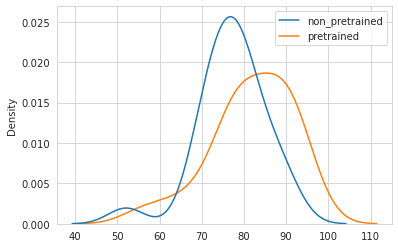

In [56]:
pre_nav = list(combined_data['Not Pretrained', 'Percent Navigated'])
npre_nav = list(combined_data['Pretrained', 'Percent Navigated'])

nav_df = pd.DataFrame([pre_nav, npre_nav]).T
nav_df.columns = ['non_pretrained', 'pretrained']

sns.kdeplot(data=nav_df)

In [3]:
model_dir = '/raid/clark/summer2021/datasets/corrected-wander-full/models'
models = os.listdir(model_dir)
models = list(filter(lambda x: "-notpretrained" in x, models))
models.sort()

In [5]:
models

['classification-alexnet-notpretrained-0.pkl',
 'classification-alexnet-notpretrained-1.pkl',
 'classification-alexnet-notpretrained-2.pkl',
 'classification-alexnet-notpretrained-3.pkl',
 'classification-densenet121-notpretrained-0.pkl',
 'classification-densenet121-notpretrained-1.pkl',
 'classification-densenet121-notpretrained-2.pkl',
 'classification-densenet121-notpretrained-3.pkl',
 'classification-densenet201-notpretrained-0.pkl',
 'classification-densenet201-notpretrained-1.pkl',
 'classification-densenet201-notpretrained-2.pkl',
 'classification-densenet201-notpretrained-3.pkl',
 'classification-resnet18-notpretrained-0.pkl',
 'classification-resnet18-notpretrained-1.pkl',
 'classification-resnet18-notpretrained-2.pkl',
 'classification-resnet18-notpretrained-3.pkl',
 'classification-resnet50-notpretrained-0.pkl',
 'classification-resnet50-notpretrained-1.pkl',
 'classification-resnet50-notpretrained-2.pkl',
 'classification-resnet50-notpretrained-3.pkl',
 'classification-squ

In [51]:
models[16:20]

['classification-resnet50-pretrained-0.pkl',
 'classification-resnet50-pretrained-1.pkl',
 'classification-resnet50-pretrained-2.pkl',
 'classification-resnet50-pretrained-3.pkl']

In [16]:
m = load_learner(model_dir + "/classification-resnet50-pretrained-0.pkl")

In [52]:
m = torch.load(model_dir + "/classification-resnet50-pretrained-0.pkl", "cuda:3")

In [70]:
import matplotlib.pyplot as plt
import sys
sys.path.append("../PycastWorld")
sys.path.append("../Gym")
from gym_pycastworld.PycastWorldEnv import PycastWorldEnv

sys.path.append("../Automator")
from AutoGen import Navigator

from fastai.vision.all import *
import datetime;

import sys
import fastprogress
from matplotlib.animation import FuncAnimation

from IPython.display import HTML
# sys.path.append("../PycastWorld")
# from gym_pycastworld.PycastWorldEnv import PycastWorldEnv  # type: ignore
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.set_device(3)
else:
    device = torch.device('cpu')

In [96]:
steps_per_episode = 1500

env = PycastWorldEnv("../Mazes/maze01.txt", 224, 224)

observation = env.reset()
frames = [observation.copy()]
model_inf = load_learner(model_dir + "/classification-resnet50-pretrained-0.pkl", cpu=False)
# model_inf = torch.load(model_dir + "/classification-resnet50-pretrained-0.pkl", "cuda:3")
model_inf.eval();

Number of texture: 6
Texture filename: ../Textures/Tiles074_2K_Color1024.png
Texture filename: ../Textures/Plaster001_2K_Color1024.png
Texture filename: ../Textures/PavingStones087_2K_Color1024.png
Texture filename: ../Textures/arrow-right-long.png
Texture filename: ../Textures/arrow-left-long.png
Texture filename: ../Textures/goal.png
Map is 21 by 21
Initial pose: 3.5, 3.5 3.14159 (Dir.WEST)
Goal position: 19, 19


In [97]:
model_inf.to("cuda:3");

In [98]:
model_inf.predict(observation)

RuntimeError: Expected tensor for argument #1 'input' to have the same device as tensor for argument #2 'weight'; but device 3 does not equal 2 (while checking arguments for cudnn_convolution)